# Demonstration of anomaly detection with CVAE using DASHlink data

**Author: Milad Memarzadeh (milad.memarzadeh@nasa.gov)**


# Import Libraries

In [28]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve, precision_recall_curve, average_precision_score
from sklearn.utils import shuffle
from source.modelsCondVAE import *
from source.utilsCondVAEs5 import *
from itertools import combinations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
k_folds = 5
train_learning_rate = 1e-4 #1e-3
finetune_learning_rate = 1e-5 #1e-4
train_num_epochs = 50
finetune_num_epochs = 5

latent_dim = 10
batch_size = 64
window_size = 10


# Load and preprocess data

In [30]:
if os.name == 'nt':
    data_dir = 'C:/Users/jed95/Documents/GitHub/anomaly_detection/dataset/yahoo_s5/A2Benchmark/'
else:
    data_dir = '/home/adlink3/Downloads/yahoo_s5/A2Benchmark/'
save_dir="./A2/"
file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]


df_list = []
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
print("Data shape:", data.shape)


Data shape: (142100, 3)


In [31]:
print("Missing values:", data.isnull().sum())
data.dropna(inplace=True)

Missing values: timestamp     0
value         0
is_anomaly    0
dtype: int64


In [32]:
scaler = MinMaxScaler()
data['value'] = scaler.fit_transform(data['value'].values.reshape(-1, 1))


# Create Sequences

In [33]:
def create_sequences(values, labels, window_size, step=1):
    sequences = []
    seq_labels = []
    for i in range(0, len(values) - window_size + 1, step):
        seq = values[i:i + window_size]
        # If any label in the sequence is anomalous (e.g., 1), set the sequence label as anomalous
        label = 1 if any(labels[i:i + window_size]) else 0
        sequences.append(seq)
        seq_labels.append(label)
    return np.array(sequences), np.array(seq_labels)


sequences, seq_labels = create_sequences(data['value'].values, data['is_anomaly'].values, window_size=window_size)
print("Sequences shape:", sequences.shape)
print("Sequence labels shape:", seq_labels.shape)



Sequences shape: (142091, 10)
Sequence labels shape: (142091,)


# Split data into labeled and unlabeled sets

In [34]:

normal_indices = np.where(seq_labels == 0)[0]
anomalous_indices = np.where(seq_labels == 1)[0]

normal_sequences = sequences[normal_indices]
normal_labels = seq_labels[normal_indices]

anomalous_sequences = sequences[anomalous_indices]
anomalous_labels = seq_labels[anomalous_indices]
print(normal_sequences.shape)
print(anomalous_sequences.shape)


(139825, 10)
(2266, 10)


In [35]:
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    normal_sequences, normal_labels, test_size=0.6, random_state=42, stratify=normal_labels)
X_train_normal, X_val_normal, y_train_normal, y_val_normal = train_test_split(
    X_train_normal, y_train_normal, test_size=0.5, random_state=42, stratify=y_train_normal)


X_train_anomalous, X_test_anomalous, y_train_anomalous, y_test_anomalous = train_test_split(
    anomalous_sequences, anomalous_labels, test_size=0.6, random_state=42, stratify=anomalous_labels)
X_train_anomalous, X_val_anomalous, y_train_anomalous, y_val_anomalous = train_test_split(
    X_train_anomalous, y_train_anomalous, test_size=0.5, random_state=42, stratify=y_train_anomalous)


In [36]:
X_train = np.concatenate([X_train_normal, X_train_anomalous], axis=0)
y_train = np.concatenate([y_train_normal, y_train_anomalous], axis=0)

X_val = np.concatenate([X_val_normal, X_val_anomalous], axis=0)
y_val = np.concatenate([y_val_normal, y_val_anomalous], axis=0)

X_test = np.concatenate([X_test_normal, X_test_anomalous], axis=0)
y_test = np.concatenate([y_test_normal, y_test_anomalous], axis=0)
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)


Training data shape: (28418, 10) (28418,)
Validation data shape: (28418, 10) (28418,)
Test data shape: (85255, 10) (85255,)


In [37]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


# Convert Data to Tensors

In [38]:
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).long()

X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).long()

X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).long()


# Create Data Loaders for Labeled and Unlabeled Data

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # Now labels are provided for all data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.labels[idx]
        return X, y


In [40]:

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #TODO adjust Shuffle training data? 
full_train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)

val_dataset = TimeSeriesDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Instantiate and Train the Conditional VAE

In [41]:
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)

            # Forward pass
            x_rec, class_logits = model(data)
            
            # Compute classification loss
            loss = criterion(class_logits, target)
            total_loss += loss.item() * data.size(0)

            # Compute accuracy
            preds = class_logits.argmax(dim=1)
            total_correct += (preds == target).sum().item()
            total_samples += data.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc


In [42]:

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
num_param = 1    # Since we have univariate time series
num_classes = 2 
scale_flag = 0   # Use Sigmoid activation in the decoder

results = {}

print('Starting k-fold cross-validation...')
time_start = time.time()
for fold, (train_idx, val2_idx) in enumerate(skf.split(np.zeros(len(y_train_tensor)), y_train_tensor.cpu().numpy())):
    print(f'Fold {fold+1}/{k_folds}')
    model_name="CondVAE_model"+str(fold+1)
    # Create data loaders for the current fold
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val2_subsampler = torch.utils.data.SubsetRandomSampler(val2_idx)
    
    train_loader = DataLoader(full_train_dataset, batch_size=batch_size, sampler=train_subsampler)
    val2_loader = DataLoader(full_train_dataset, batch_size=batch_size, sampler=val2_subsampler)
    
    model = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
    optimizer = optim.Adam(model.parameters(), lr=train_learning_rate)
    
    model = train_model(
    model,
    optimizer,
    train_loader,
    num_epochs=train_num_epochs,
    save=True,
    save_dir=save_dir,
    model_name=model_name)
    
    # Evaluate the model on validation data
    val_loss, val_acc = evaluate_model(model, val2_loader)
    
    # Save the results for this fold
    results[fold] = {'val_loss': val_loss, 'val_acc': val_acc}
    
    print(f'Fold {fold+1} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

time_end = time.time()
print(f'Total time taken for k-fold cross-validation: {time_end - time_start} seconds')
buffer = io.BytesIO()
torch.save(model.state_dict(), buffer)



Starting k-fold cross-validation...
Fold 1/5


KeyboardInterrupt: 

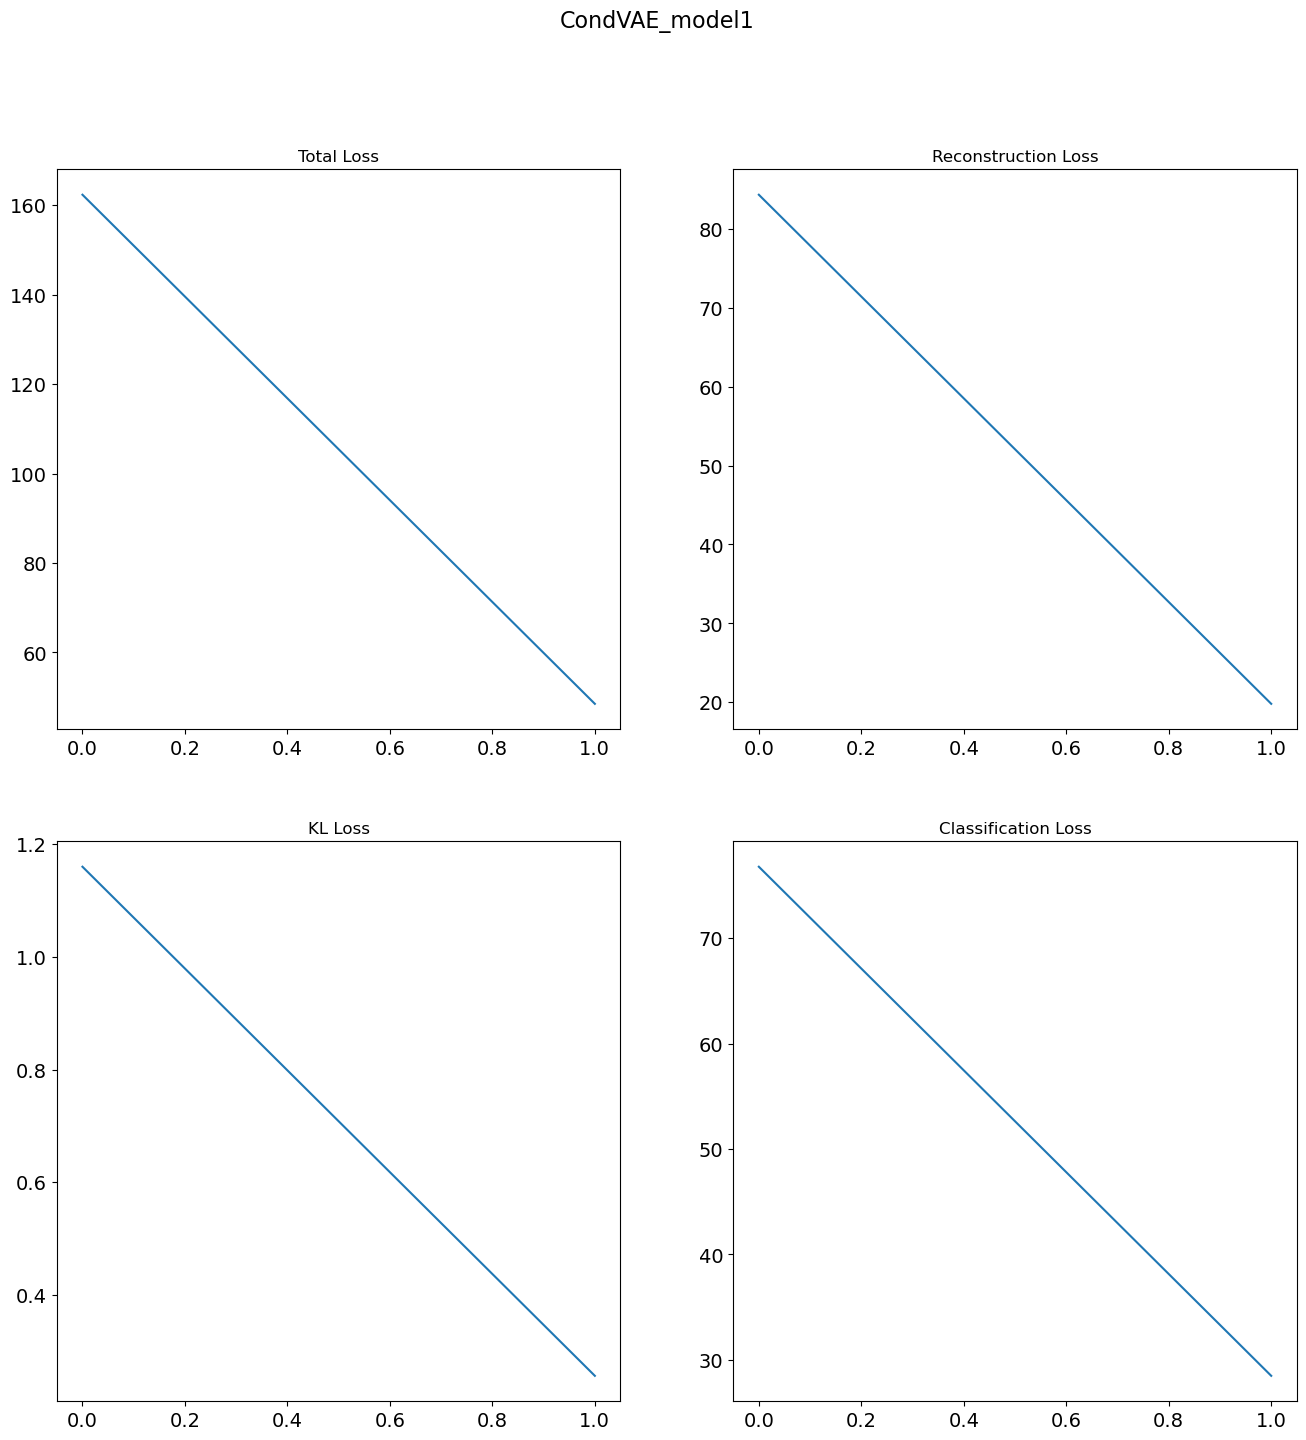

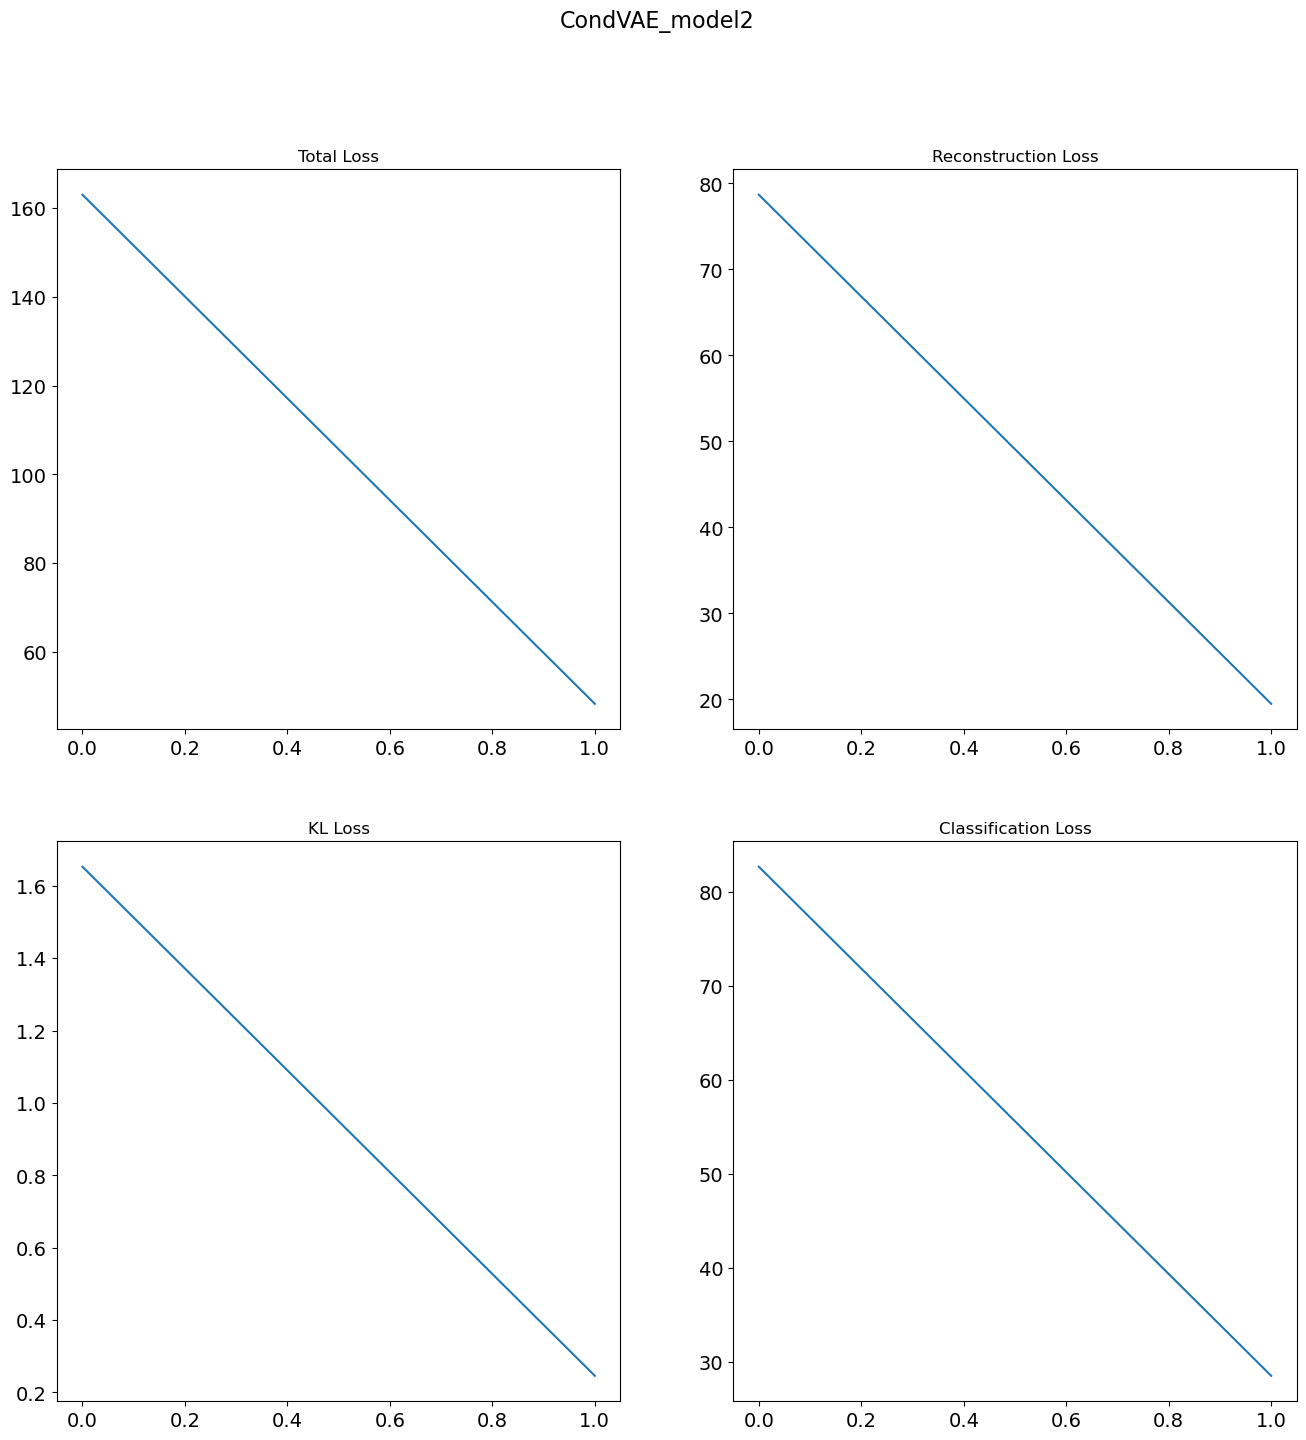

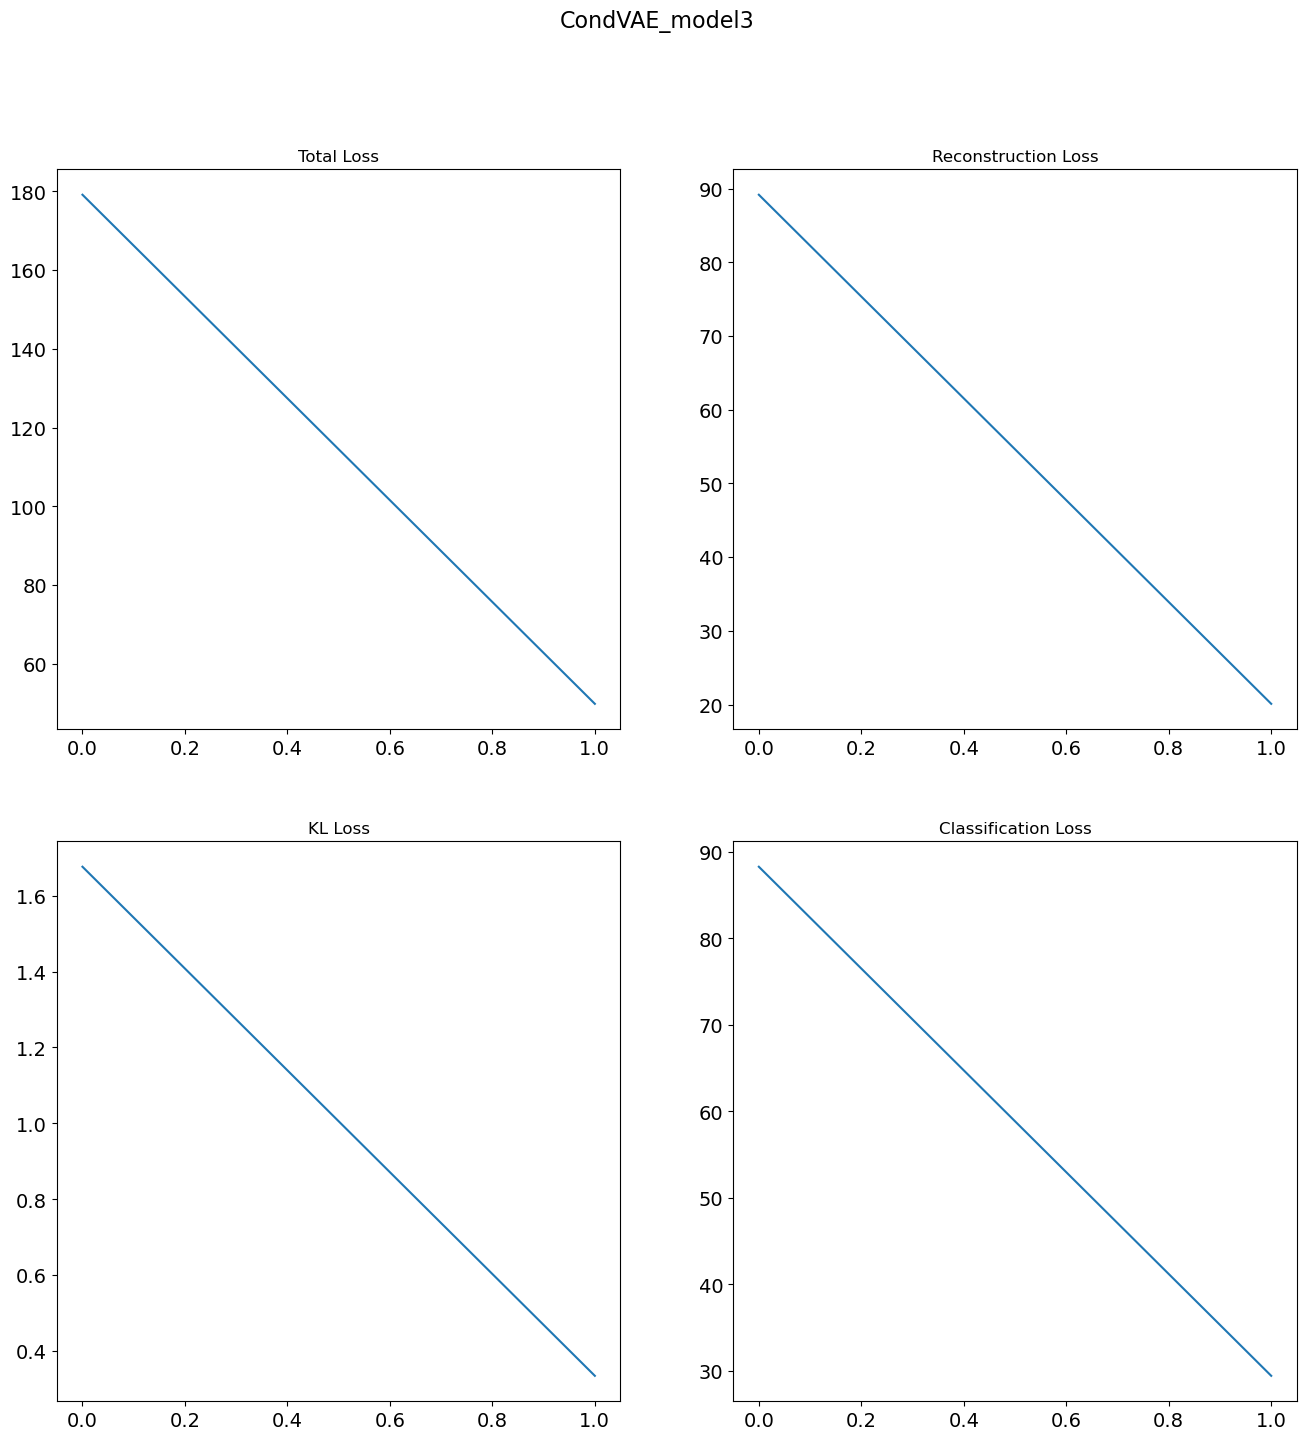

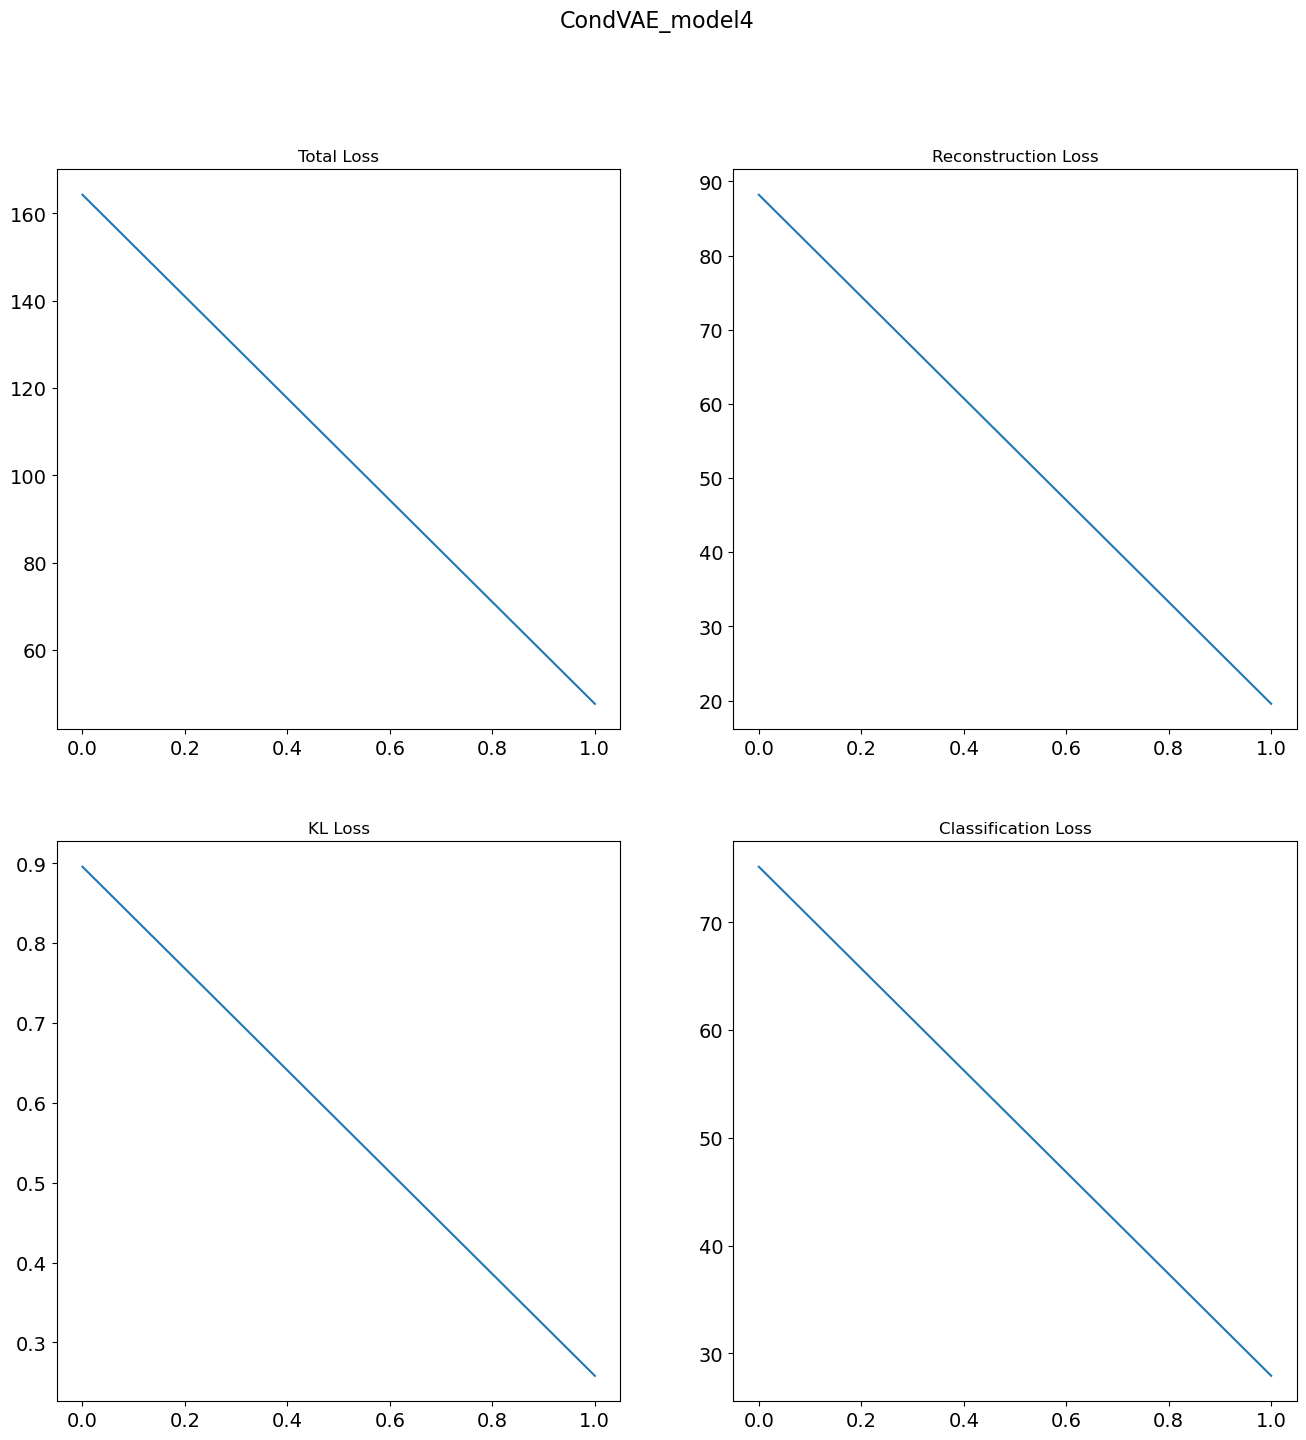

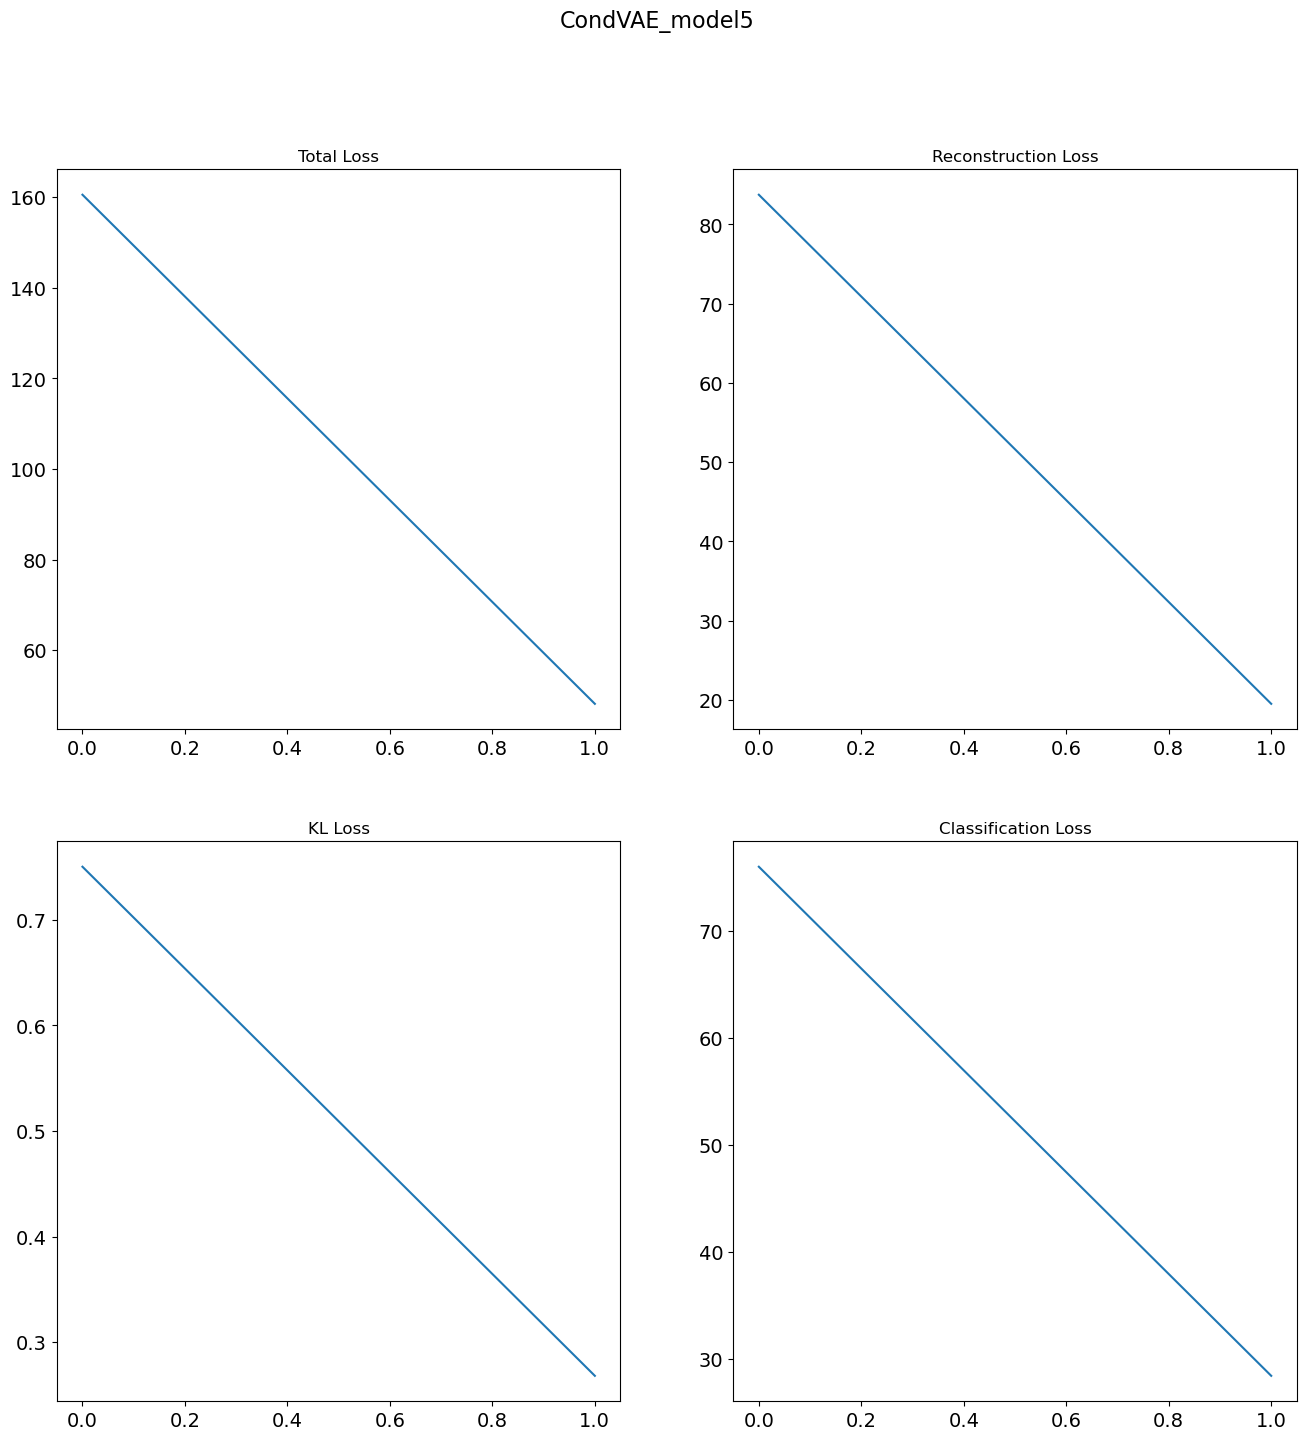

In [ ]:
def plot_training_loss(model_name, save_dir):
    training_traj = np.load(save_dir+model_name+"_training_loss.npz")

    total_loss = training_traj['training_total_loss']
    rec_loss = training_traj['training_rec_loss']
    kl_loss = training_traj['training_kl_loss']
    class_loss = training_traj['training_class_loss']
    plt.figure(figsize=(16, 16))
    plt.suptitle(model_name, fontsize=16)
    plt.subplot(2, 2, 1)
    plt.title("Total Loss", fontsize=12)
    plt.plot(range(len(total_loss)), total_loss)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.subplot(2, 2, 2)
    plt.title("Reconstruction Loss", fontsize=12)
    plt.plot(range(len(total_loss)), rec_loss)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.subplot(2, 2, 3)
    plt.title("KL Loss", fontsize=12)
    plt.plot(range(len(total_loss)), kl_loss)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.subplot(2, 2, 4)
    plt.title("Classification Loss", fontsize=12)
    plt.plot(range(len(total_loss)), class_loss)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
for fold in range(k_folds):
    plot_training_loss("CondVAE_model"+str(fold+1), save_dir)

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"]).plot(cmap=plt.cm.Blues)

# Initialize 3 new models for fine-tuning

In [ ]:
buffer.seek(0) 
model_medium = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
model_medium.load_state_dict(torch.load(buffer))
model_medium = model_medium.to(device)

buffer.seek(0)
model_strong = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
model_strong.load_state_dict(torch.load(buffer))
model_strong = model_strong.to(device)
buffer.seek(0)
model_random = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)
model_random.load_state_dict(torch.load(buffer))
model_random = model_random.to(device)


# Verify the 3 new models

In [ ]:
# Initialize a flag
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")
# Initialize a flag
models_identical = True
original_state_dict = model_random.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")
# Initialize a flag
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_strong.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")

The saved and loaded models are identical.
The saved and loaded models are identical.
The saved and loaded models are identical.


# Evaluate the Model and Detect Anomalies

Precision = 100.0%, recall = 0.59% and F1-score = 1.17%


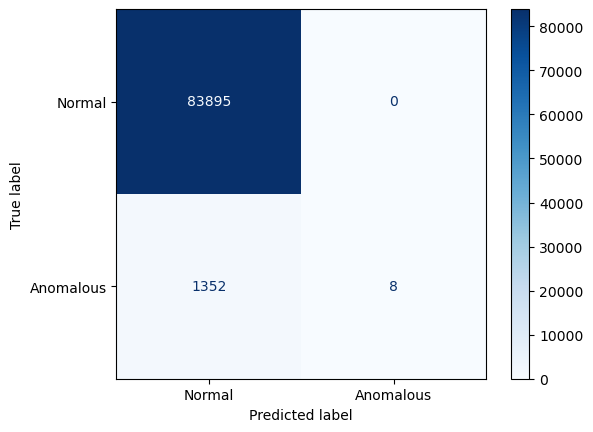

In [ ]:
def compute_anomaly_scores(model, data_loader):
    model.eval()
    rec_errors = []
    anomaly_probs = []
    true_labels = []
    predictions = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)

            x_rec, class_logits = model(X_batch)
            y_probs = F.softmax(class_logits, dim=1)

            # Reconstruction error
            rec_error = torch.mean((X_batch - x_rec) ** 2, dim=[1, 2])

            # Classification probability for anomaly class
            anomaly_prob = y_probs[:, 1]

            # Combine scores
            #anomaly_score = rec_error * anomaly_prob
            rec_errors.extend(rec_error.cpu().numpy())
            anomaly_probs.extend(anomaly_prob.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
            predictions.extend(torch.argmax(class_logits, dim=1).cpu().numpy())

    return np.array(rec_errors), np.array(anomaly_probs), np.array(true_labels), np.array(predictions)

# Compute anomaly scores
train_rec_errors, train_anomaly_probs, train_true_labels, train_predictions = compute_anomaly_scores(model, train_loader)
val_rec_errors, val_anomaly_probs, val_true_labels, val_predictions = compute_anomaly_scores(model, val_loader)
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model, test_loader)

plot_confusion_matrix(test_true_labels, test_predictions)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

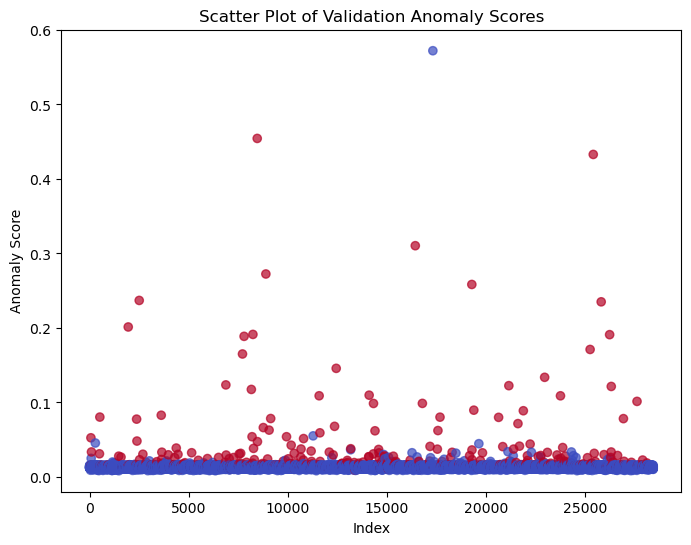

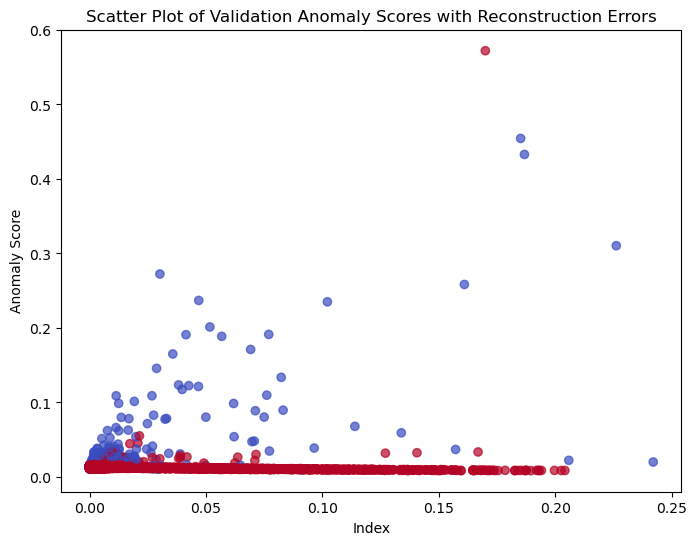

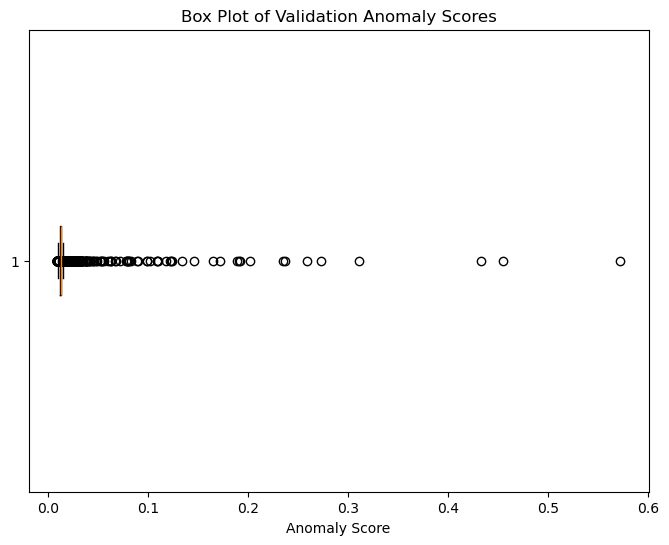

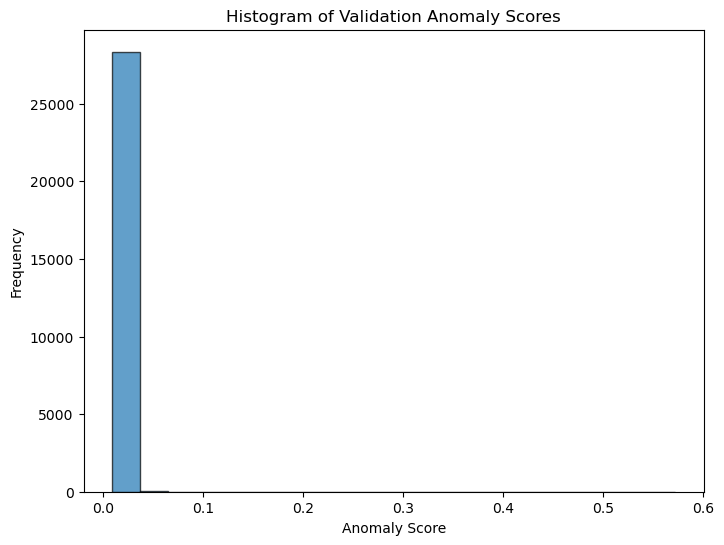

In [ ]:

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(val_anomaly_probs)), val_anomaly_probs, alpha=0.7, c=(val_true_labels!=val_predictions), cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(val_rec_errors, val_anomaly_probs, alpha=0.7, c=(val_true_labels==val_predictions), cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores with Reconstruction Errors")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()

# Box Plot
plt.figure(figsize=(8, 6))
plt.boxplot(val_anomaly_probs, vert=False)
plt.title("Box Plot of Validation Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.show()

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(val_anomaly_probs, bins=20, alpha=0.7, edgecolor='black')
plt.title("Histogram of Validation Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


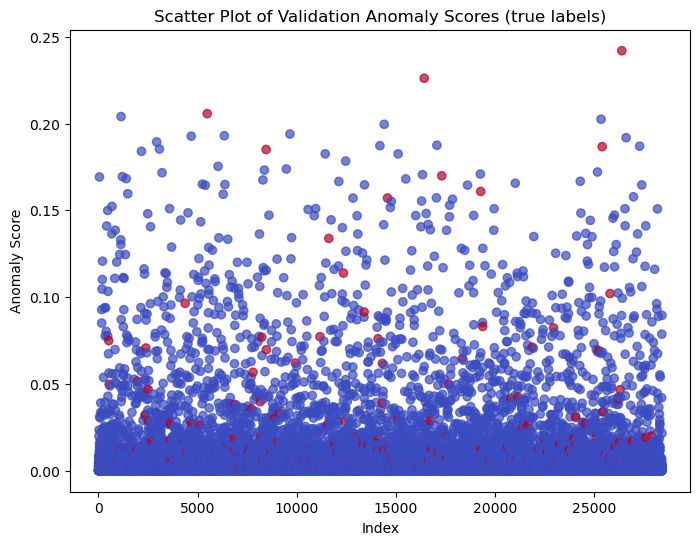

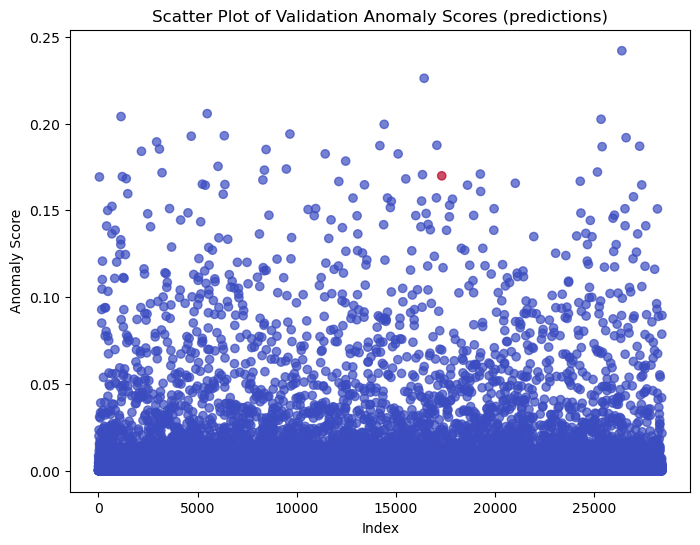

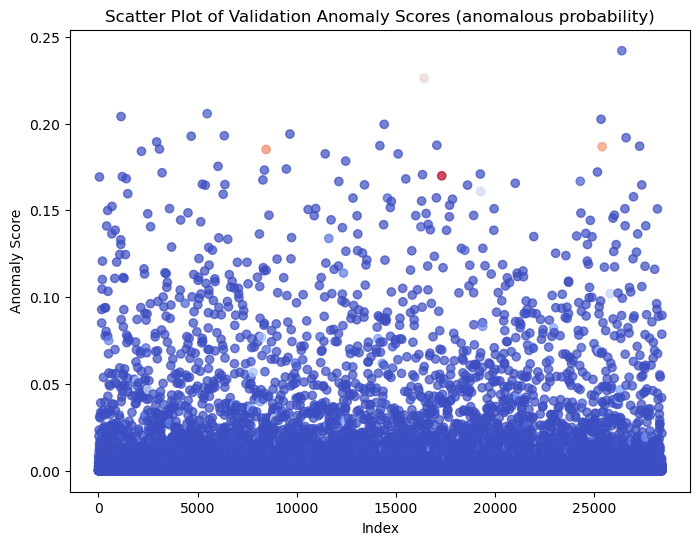

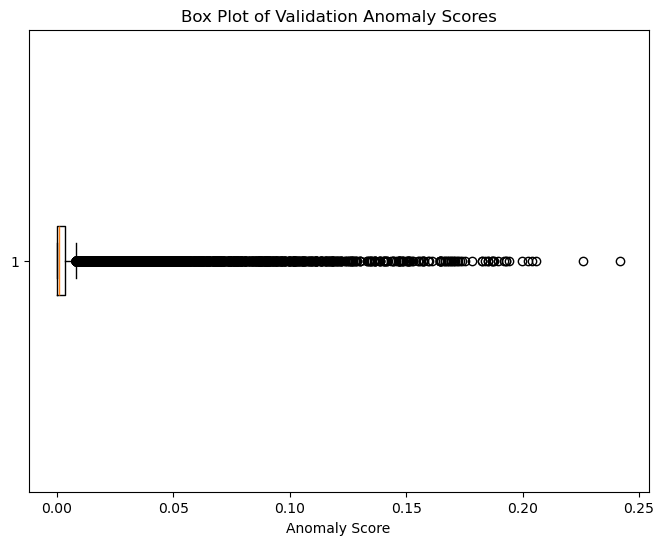

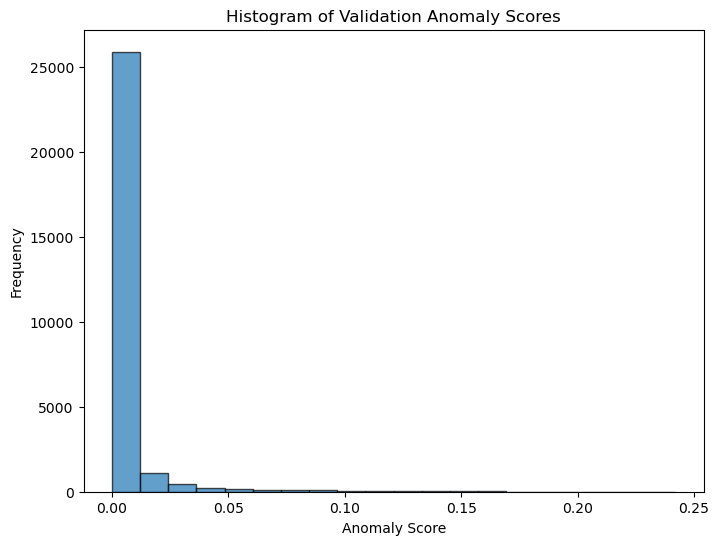

In [ ]:

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(val_rec_errors)), val_rec_errors, alpha=0.7, c=val_true_labels, cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores (true labels)")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()
# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(val_rec_errors)), val_rec_errors, alpha=0.7, c=val_predictions, cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores (predictions)")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()
# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(val_rec_errors)), val_rec_errors, alpha=0.7, c=val_anomaly_probs, cmap='coolwarm')
plt.title("Scatter Plot of Validation Anomaly Scores (anomalous probability)")
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.show()

# Box Plot
plt.figure(figsize=(8, 6))
plt.boxplot(val_rec_errors, vert=False)
plt.title("Box Plot of Validation Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.show()

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(val_rec_errors, bins=20, alpha=0.7, edgecolor='black')
plt.title("Histogram of Validation Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


# Retrain

In [ ]:
# Determine thresholds
#lower_percentile = 62.5
#upper_percentile = 37.5
#lower_threshold = np.percentile(val_anomaly_probs, lower_percentile)
#upper_threshold = np.percentile(val_anomaly_probs, upper_percentile)


# Select medium-score data
medium_score_indices = np.where((val_anomaly_probs >= 0.05) & (val_anomaly_probs <= 0.95))[0]
X_medium = X_val[medium_score_indices]
y_medium = y_val[medium_score_indices]
print("Medium-score data shape:", X_medium.shape, y_medium.shape)
X_medium_tensor = torch.tensor(X_medium).float()
y_medium_tensor = torch.tensor(y_medium).long()
# data loader
medium_dataset = TimeSeriesDataset(X_medium_tensor, y_medium_tensor)
medium_loader = DataLoader(medium_dataset, batch_size=batch_size, shuffle=False)



Medium-score data shape: (47, 10) (47,)


In [ ]:
# Determine thresholds
#lower_percentile = 12.5
#upper_percentile = 87.5
#lower_threshold = np.percentile(val_anomaly_probs, lower_percentile)
#upper_threshold = np.percentile(val_anomaly_probs, upper_percentile)

# Select strong-score data
strong_score_indices = np.where((val_anomaly_probs <= 0.01) | (val_anomaly_probs >= 0.99))[0]
X_strong = X_val[strong_score_indices]
y_strong = y_val[strong_score_indices]
print("Strong-score data shape:", X_strong.shape, y_strong.shape)
X_strong_tensor = torch.tensor(X_strong).float()
y_strong_tensor = torch.tensor(y_strong).long()
# data loader
strong_dataset = TimeSeriesDataset(X_strong_tensor, y_strong_tensor)
strong_loader = DataLoader(strong_dataset, batch_size=batch_size, shuffle=False)



Strong-score data shape: (174, 10) (174,)


In [ ]:
# Optional: Set a random seed for reproducibility
np.random.seed(42)

# Define the fraction of data to select
sample_fraction = 0.25
total_samples = len(val_anomaly_probs)
sample_size = int(sample_fraction * total_samples)

# Randomly select unique indices without replacement
random_score_indices = np.random.choice(total_samples, size=sample_size, replace=False)

# Select the corresponding data and labels
X_random = X_val[random_score_indices]
y_random = y_val[random_score_indices]
print("Random data shape:", X_random.shape, y_random.shape)
# Convert to PyTorch tensors
X_random_tensor = torch.tensor(X_random).float()
y_random_tensor = torch.tensor(y_random).long()

# Create the dataset and data loader
random_dataset = TimeSeriesDataset(X_random_tensor, y_random_tensor)
random_loader = DataLoader(random_dataset, batch_size=batch_size, shuffle=False)


Random data shape: (7104, 10) (7104,)


Epoch [1/5], Total Loss: 2.7123, Rec Loss: 0.5986, KL Div: 0.0181, Class Loss: 2.0956
Epoch [2/5], Total Loss: 2.6814, Rec Loss: 0.5854, KL Div: 0.0183, Class Loss: 2.0778
Epoch [3/5], Total Loss: 2.6498, Rec Loss: 0.5714, KL Div: 0.0184, Class Loss: 2.0600
Epoch [4/5], Total Loss: 2.6224, Rec Loss: 0.5616, KL Div: 0.0186, Class Loss: 2.0422
Epoch [5/5], Total Loss: 2.6425, Rec Loss: 0.5992, KL Div: 0.0187, Class Loss: 2.0246
Time elapsed:  0.023953914642333984
Mismatch found at layer: encoder.fc_layers.0.weight
The models are not identical.


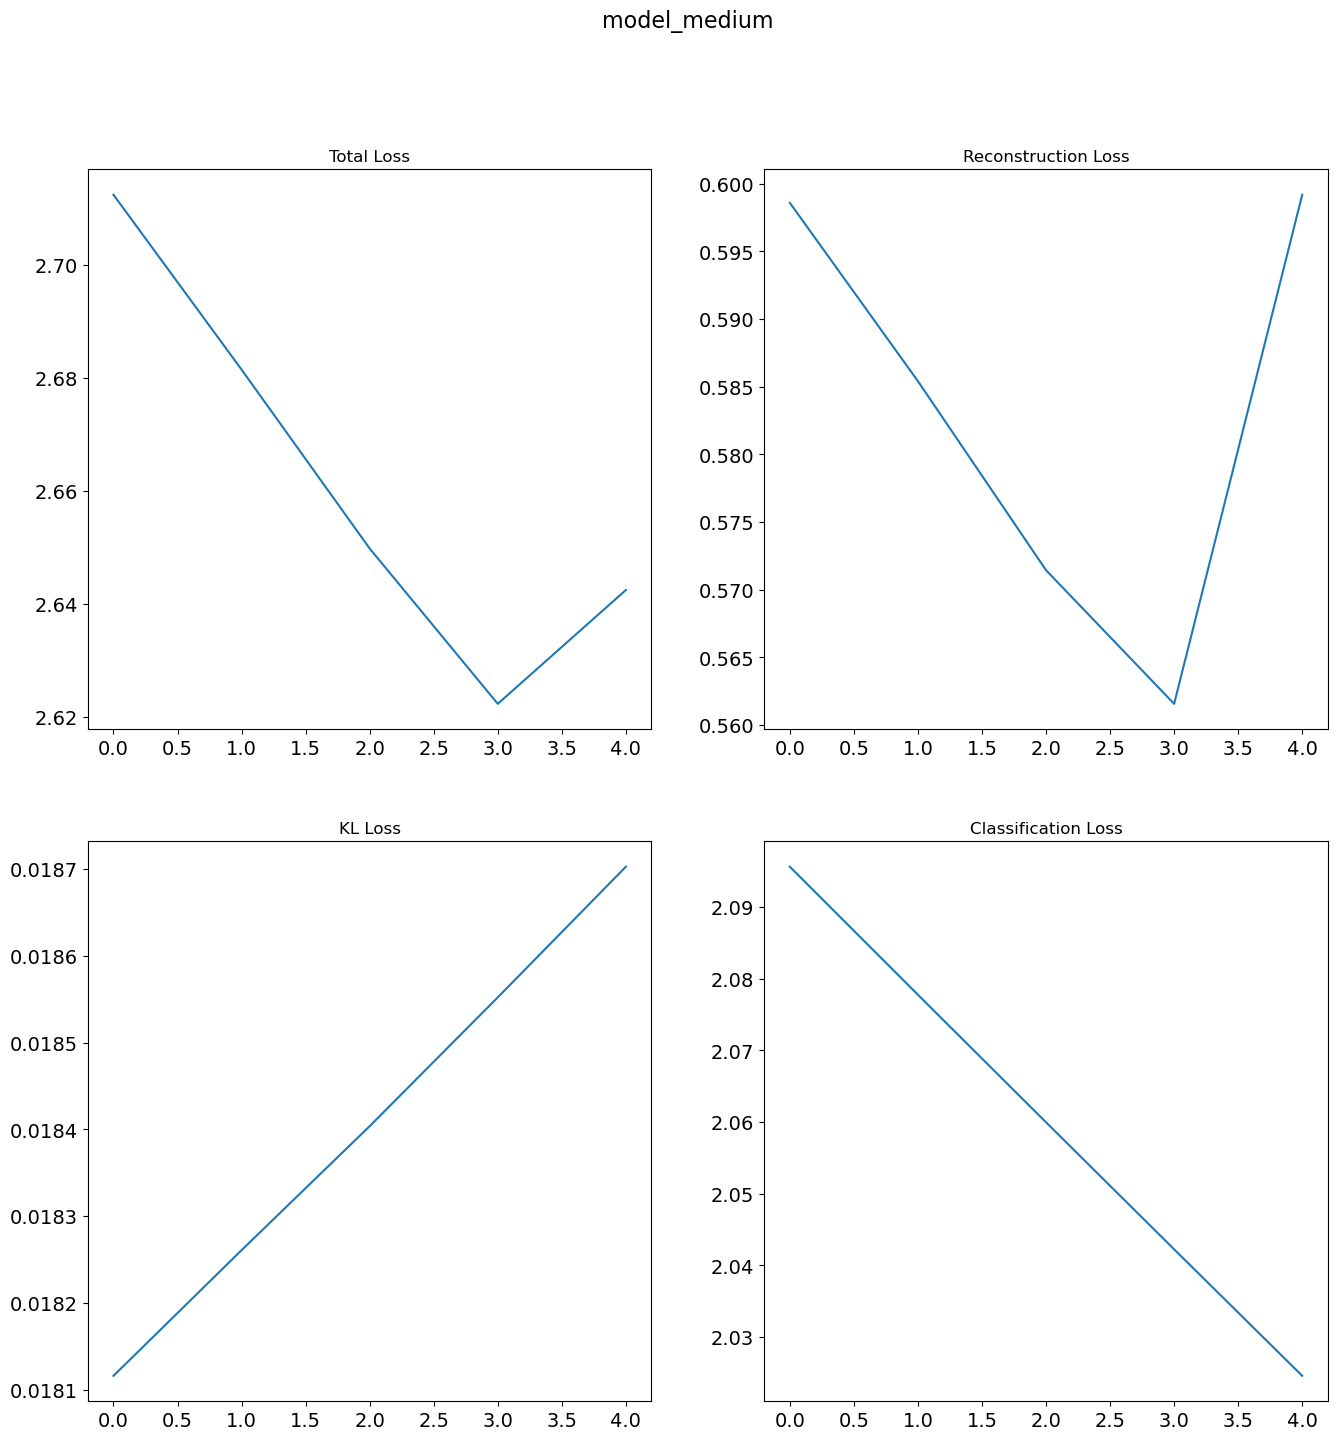

In [ ]:
# Finetune the model
model_name = "model_medium"
optimizer = optim.Adam(model_medium.parameters(), lr=finetune_learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-7)
model_medium = train_model(model_medium, optimizer, medium_loader, num_epochs=finetune_num_epochs, model_name=
                           model_name, save_dir=save_dir, save=True)
plot_training_loss(model_name, save_dir)
models_identical = True
original_state_dict = model.state_dict()
loaded_state_dict = model_medium.state_dict()
# Compare each parameter
for key in original_state_dict:
    original_param = original_state_dict[key]
    loaded_param = loaded_state_dict[key]
    if not torch.equal(original_param, loaded_param):
        print(f"Mismatch found at layer: {key}")
        models_identical = False
        break

if models_identical:
    print("The saved and loaded models are identical.")
else:
    print("The models are not identical.")

In [ ]:
optimizer = optim.Adam(model_strong.parameters(), lr=finetune_learning_rate)
model_name = "model_strong"
model_strong = train_model(model_strong, optimizer, strong_loader, num_epochs=finetune_num_epochs, model_name=model_name)
plot_training_loss(model_name, save_dir)

Epoch [1/5], Total Loss: 4.0754, Rec Loss: 3.9335, KL Div: 0.0405, Class Loss: 0.1014
Epoch [2/5], Total Loss: 4.0988, Rec Loss: 3.9576, KL Div: 0.0407, Class Loss: 0.1005
Epoch [3/5], Total Loss: 4.1230, Rec Loss: 3.9822, KL Div: 0.0411, Class Loss: 0.0997
Epoch [4/5], Total Loss: 4.1407, Rec Loss: 4.0003, KL Div: 0.0414, Class Loss: 0.0990
Epoch [5/5], Total Loss: 4.1126, Rec Loss: 3.9724, KL Div: 0.0419, Class Loss: 0.0983
Time elapsed:  0.038694143295288086


FileNotFoundError: [Errno 2] No such file or directory: './A2/model_strong_training_loss.npz'

In [ ]:
model_name = "model_random"
optimizer = optim.Adam(model_random.parameters(), lr=finetune_learning_rate)
model_random = train_model(model_random, optimizer, random_loader, num_epochs=finetune_num_epochs, model_name=model_name)
plot_training_loss(model_name, save_dir)

In [ ]:
# Combine data
expanded_medium_data = np.concatenate((X_train, X_medium), axis=0)
expanded_medium_labels = np.concatenate((y_train, y_medium), axis=0)
X_expanded_medium_tensor = torch.tensor(expanded_medium_data).float()
y_expanded_medium_tensor = torch.tensor(expanded_medium_labels).long()
# Create new dataset and loader
expanded_medium_dataset = TimeSeriesDataset(X_expanded_medium_tensor, y_expanded_medium_tensor)
expanded_medium_loader = DataLoader(expanded_medium_dataset, batch_size=batch_size, shuffle=False)
model2_medium = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)

# Define optimizer
model_name = "model2_medium"
optimizer = optim.Adam(model2_medium.parameters(), lr=train_learning_rate)
model2_medium = train_model(model2_medium, optimizer, expanded_medium_loader, num_epochs=train_num_epochs, model_name=model_name)
plot_training_loss(model_name, save_dir)

In [ ]:
expanded_strong_data = np.concatenate((X_train, X_strong), axis=0)
expanded_strong_labels = np.concatenate((y_train, y_strong), axis=0)
X_expanded_strong_tensor = torch.tensor(expanded_strong_data).float()
y_expanded_strong_tensor = torch.tensor(expanded_strong_labels).long()
# Create new dataset and loader
expanded_strong_dataset = TimeSeriesDataset(X_expanded_strong_tensor, y_expanded_strong_tensor)
expanded_strong_loader = DataLoader(expanded_strong_dataset, batch_size=batch_size, shuffle=False)
model2_strong = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)

# Define optimizer
model_name = "model2_strong"
optimizer = optim.Adam(model2_strong.parameters(), lr=train_learning_rate)
model2_strong = train_model(model2_strong, optimizer, expanded_strong_loader, num_epochs=train_num_epochs, model_name="model2_strong")
plot_training_loss(model_name, save_dir)

In [ ]:
expanded_random_data = np.concatenate((X_train, X_random), axis=0)
expanded_random_labels = np.concatenate((y_train, y_random), axis=0)
X_expanded_random_tensor = torch.tensor(expanded_random_data).float()
y_expanded_random_tensor = torch.tensor(expanded_random_labels).long()
# Create new dataset and loader
expanded_random_dataset = TimeSeriesDataset(X_expanded_random_tensor, y_expanded_random_tensor)
expanded_random_loader = DataLoader(expanded_random_dataset, batch_size=batch_size, shuffle=False)
model2_random = VAE(latent_dim, num_param, window_size, num_classes, scale_flag).to(device)

# Define optimizer
model_name = "model2_random"
optimizer = optim.Adam(model2_random.parameters(), lr=train_learning_rate)
model2_random = train_model(model2_random, optimizer, expanded_random_loader, num_epochs=train_num_epochs, model_name="model2_random")
plot_training_loss(model_name, save_dir)

In [ ]:
# Assuming you have already defined and initialized your models:
# model, model_medium, model_random, model_strong

# Dictionary of models with their names for easy reference
models = {
    'model': model,
    'model_medium': model_medium,
    'model_random': model_random,
    'model_strong': model_strong,
    'model2_medium': model2_medium,
    'model2_random': model2_random,
    'model2_strong': model2_strong
}

# Generate all possible unique pairs of models
model_pairs = list(combinations(models.items(), 2))

# Lists to keep track of identical and different model pairs
identical_pairs = []
different_pairs = []

# Function to compare two models
def compare_models(model1, model2, name1, name2):
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()
    
    # First, check if both models have the same set of keys (layers)
    keys1 = set(state_dict1.keys())
    keys2 = set(state_dict2.keys())
    
    if keys1 != keys2:
        missing_in_1 = keys2 - keys1
        missing_in_2 = keys1 - keys2
        if missing_in_1:
            
            print(f"Model '{name1}' is missing layers: {missing_in_1}")
        if missing_in_2:
            
            print(f"Model '{name2}' is missing layers: {missing_in_2}")
        return False  # Layers mismatch implies models are different
    
    # Compare each parameter tensor
    for key in state_dict1:
        param1 = state_dict1[key]
        param2 = state_dict2[key]
        
        if not torch.equal(param1, param2):
            #print(f"Mismatch found in layer '{key}' between '{name1}' and '{name2}'.")
            return False  # Found a mismatch
    
    return True  # All parameters match

# Iterate through each pair and compare
for (name1, model1), (name2, model2_medium) in model_pairs:
    print(f"Comparing '{name1}' with '{name2}':")
    are_identical = compare_models(model1, model2_medium, name1, name2)
    
    if are_identical:
        identical_pairs.append((name1, name2))
        print(f"--> '{name1}' and '{name2}' are IDENTICAL.\n")
    else:
        different_pairs.append((name1, name2))
        print(f"--> '{name1}' and '{name2}' are DIFFERENT.\n")

# Summary of results
print("=== Comparison Summary ===\n")

if identical_pairs:
    print("Identical Model Pairs:")
    for name1, name2 in identical_pairs:
        print(f" - {name1} and {name2}")
else:
    print("No identical model pairs found.")

print()

if different_pairs:
    print("Different Model Pairs:")
    for name1, name2 in different_pairs:
        print(f" - {name1} and {name2}")
else:
    print("No different model pairs found.")


In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model_medium, test_loader)

plot_confusion_matrix(test_true_labels, test_predictions)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model_strong, test_loader)
plot_confusion_matrix(test_true_labels, test_predictions)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model_random, test_loader)
plot_confusion_matrix(test_true_labels, test_predictions)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model2_medium, test_loader)
plot_confusion_matrix(test_true_labels, test_predictions)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model2_strong, test_loader)
plot_confusion_matrix(test_true_labels, test_predictions)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))

In [ ]:
test_rec_errors, test_anomaly_probs, test_true_labels, test_predictions = compute_anomaly_scores(model2_random, test_loader)
plot_confusion_matrix(test_true_labels, test_predictions)
info = precision_recall_fscore_support(test_true_labels, test_predictions, pos_label=1)
print("Precision = {}%, recall = {}% and F1-score = {}%".format(np.round(info[0][1]*100, 2),
                                                                np.round(info[1][1]*100, 2),
                                                                np.round(info[2][1]*100, 2)))